# **Préparez des données pour un organisme de santé publique**

![logo.JPG](data/img/logo.JPG)

L'agence "Santé publique France" a lancé un **appel à projets pour rendre les données de santé plus accessibles**.
L’agence souhaite faire explorer et visualiser des données, pour que ses agents puissent les exploiter.

L'anayse est basée sur le jeu de données <a href="https://world.openfoodfacts.org/">Open Food</a>

---

## Sommaire

<ol>
    <li><a href="#environnement">Environnement de développement</a></li>
        <ol>
            <li><a href="#installation">Installation de l'environnement</a></li>
            <li><a href="#librairies">Import des librairies</a></li>
            <li><a href="#fonctions">Fonctions utilitaires</a></li>
        </ol>
    <li><a href="#presentation">Présentation générale du jeu de données</a></li>
    <li><a href="#nettoyage">Nettoyage du jeu de données</a></li>
    <li><a href="#selection">Sélection des données à étudier</a></li>
    <li><a href="#analyse">Analyse des données sélectionnées</a></li>
</ol>

<a id="environnement"></a>
# Environnement de développement

<a id="installation"></a>
### Installation de l'environnement

Un environnement virtuel a été créé pour assurer l’isolement du projet et la gestion des dépendances.
Les informations de cet environnement (son nom et ses dépendances) sont précisées dans le fichier **environment.yml**

L'installation de l'environnement virtuel est possible à partir de ce fichier, dans un invite de commande lancer la commande :

<code>conda env create -f environment.yml</code>

<a id="librairies"></a>
### Import des librairies

In [321]:
# Import des librairies python spécialisées dans le Jupyter Notebook
import pandas as pd
import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import decomposition, preprocessing
from sklearn.impute import KNNImputer

In [322]:
# Réglage des graphiques
plt.style.use('seaborn-whitegrid')

plt.rc('font', size=12)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

dims_fig = (25,35)

<a id="fonctions"></a>
### Fonctions utilitaires

Fonctions utilisées pour automatiser l'analyse des données

In [323]:
######################################## Description des données #######################################

# Affiche la taille du jeu de données
def displayDataShape(data):
    shape = data.shape
    print(f"Le jeu de données contient : {shape[0]} lignes et {shape[1]} colonnes\n")

# Affichage des Nan en %
def displayNanPercent(data):
    missing_values = pd.DataFrame((data.isna().mean()*100).sort_values())
    missing_values.columns = ['Valeurs manquantes en %']
    return missing_values

# Affiche le nombre de valeurs uniques pour chaque colonne dans le tableau passé en paramètres
def displayNbrUnique(data, columns):
    nbr_uniques = []

    for column in columns:
        nbr_uniques.append(data[column].nunique())

    return pd.Series(nbr_uniques, index=columns)

# Affiche les informations supprimées entre le data et le data nettoyé
def displayInfosDataCleaned(data, data_cleaned):
    print(f"Nombre de lignes supprimées : {data.shape[0] - data_cleaned.shape[0]}")
    print(f"Nombre de colonnes supprimées : {data.shape[1] - data_cleaned.shape[1]}")
    print(f"Colonnes supprimées : {[col for col in data.columns if col not in data_cleaned.columns]}\n")
    displayDataShape(data_cleaned)


######################################## Nettoyage et Manipulation des données #######################################

# Supprime les colonnes dont le taux de remplissage est inférieur à la valeur (limit_nan) en paramètre
def filterDataColumnByNan(data, limit_nan=0.75):
    return data[data.columns[data.isna().mean() <= limit_nan]].copy()

# Supprime les lignes dont les valeurs nutritionnelles ne sont pas renseignées
def filterDataRowByNan(data, limit_nan=1):
    nutriment_amount_tag = "_100g"
    data_columns_filtered = data[[col for col in data.columns if col.endswith(nutriment_amount_tag)]]
    index_with_nan = data_columns_filtered.index[data_columns_filtered.isnull().mean(axis=1) == limit_nan]

    return data.drop(index=index_with_nan).copy()

# Supprime les lignes dont les valeurs de la colonne en paramètre sont nulles
def filterDataRowByNanInColumn(data, column_name):
    return data[data[column_name].notna()].copy()

# Retourne 2 tableaux contenant les noms des variables quantitatives et qualitatives
def categoriseVariables(data):
    infos_type = data.dtypes
    quantitative_columns = []
    qualitative_columns = []

    for index in infos_type.index:
        if (infos_type[index] == 'float') | (infos_type[index] == 'int'):
            quantitative_columns.append(index)
        else:
            qualitative_columns.append(index)

    return quantitative_columns, qualitative_columns

# Transforme les valeurs des colonnes en minuscules
def lowerStringInColumns(data, columns):
    new_data = data.copy()
    for column in columns:
        new_data[column] = new_data[column].str.lower()

    return new_data

# Supprime les valeurs en dehors d'un interval donnée dans les colonnes
def cleanDataOutInterval(data, columns, min, max):
    for column in columns:
        if "_100g" in column and "energy" not in column and "score" not in column:
            data[column] = data[column].apply(replaceMinMaxInColumn, args=(min, max, np.nan))

    return data.copy()

# Remplace les valeurs à 0 dans les colonnes par la valeur NaN
def cleanZeroValuesInData(data, columns):
    for column in columns:
        data[column] = data[column].apply(replaceValuesInColumn, args=(0, np.nan))

    return data.copy()

# Remplace une valeur spécifique dans les colonnes par une nouvelle valeur
def cleanDataQuali(data, columns, old_value, new_value):
    for column in columns:
        data[column] = data[column].apply(replaceValuesInColumn, args=(old_value, new_value))

    return data.copy()

# Remplace les valeurs en dehors d'un interval donnée par une nouvelle valeur
def replaceMinMaxInColumn(value, min, max, new_value):
    if (value < min) | (value > max):
        value = new_value
    return value

# Remplace une valeur spécifique par une nouvelle valeur
def replaceValuesInColumn(value, old_value, new_value):
    if value == old_value:
        value = new_value

    return value

# Supprime les outliers dans les colonnes par la méthode de l'écart inter-quartile
def removeOutliers(data, columns):
    Q1 = data[columns].quantile(0.25)
    Q3 = data[columns].quantile(0.75)
    EI = Q3 - Q1

    outliers = (data[columns] >= (Q1 - 1.5 * EI)) & (data[columns] <= (Q3 + 1.5 * EI))

    return outliers


######################################## Affichage des graphiques #######################################

def drawHist(data, columns, dims_fig):
    nbr_rows = int(len(columns)/3) + 1
    index = 1
    plt.figure(figsize=dims_fig)
    for column in columns:
        plt.subplot(nbr_rows, 3, index)
        plt.hist(data[column])
        plt.xlabel(f"{column}")
        plt.ylabel("Nombre d'aliments")
        plt.title(f"Histogramme - {column}")
        index += 1
    plt.show()

def drawBoxPlot(data, columns, dims_fig):
    nbr_rows = int(len(columns)/3) + 1
    index = 1
    plt.figure(figsize=dims_fig)
    for column in columns:
        plt.subplot(nbr_rows, 3, index)
        sns.boxplot(x=data[column])
        plt.xlabel(column)
        plt.title(f"Boite à moustaches pour {column}")
        index += 1
    plt.show()

def drawPieplot(data, columns, dims_fig):
    nbr_rows = int(len(columns)/2) + 1
    index = 1
    #plt.figure(figsize=dims_fig)
    for column in columns:
        values_name = data[column].value_counts().index
        data_sum = data[column].value_counts()
        iteration = 0
        for value in values_name:
            if iteration >= 30:
                break
            elif data_sum[value]/data_sum.sum()*100 >= 1.5:
                iteration+= 1
            else:
                break

        data_bis = data[column].where(data[column].isna() | data[column].isin(data[column].value_counts().index[:iteration]), other='other')

        if 'other' not in data_bis.value_counts().index:
            plt.subplot(nbr_rows, 2, index)
            data_bis.value_counts().plot.pie(figsize=dims_fig,
                                                autopct='%1.1f%%',
                                                startangle = 60,
                                                rotatelabels = True,
                                                pctdistance = 0.85)
            plt.ylabel("Nombre d'aliments")
            plt.title(f"Répartition des aliments par {column}", pad=50)
            index += 1
        elif data_bis.value_counts()['other']/data_bis.value_counts().sum()*100 < 60:
            plt.subplot(nbr_rows, 2, index)
            data_bis.value_counts().plot.pie(figsize=dims_fig,
                                             autopct='%1.1f%%',
                                             startangle = 60,
                                             rotatelabels = True,
                                             pctdistance = 0.85)
            plt.ylabel("Nombre d'aliments")
            plt.title(f"Répartition des aliments par {column}", pad=50)
            index += 1
    plt.show

def drawRepartitionHist(data, columns, repartition_column):
    columns_copy = columns.copy()
    columns_copy.remove(repartition_column)

    REPARTITION_VALUES = []
    for value in data[repartition_column].unique():
        if (str(value) != 'nan'):
            REPARTITION_VALUES.append(value)

    REPARTITION_VALUES.sort()

    for column in columns_copy:
        values_name = data[column].value_counts().index
        data_sum = data[column].value_counts()
        iteration = 0
        for value in values_name:
            if iteration >= 30:
                break
            elif data_sum[value]/data_sum.sum()*100 >= 1.5:
                iteration+= 1
            else:
                break

        if iteration != 0:
            top_values = f'top_{column}'

            data.loc[:,top_values] = data[column].where(data[column].isna() | data[column].isin(data[column].value_counts().index[:iteration]), other='other')

            TOP_VALUES = tuple(data[top_values].value_counts().index)

            fig = px.histogram(data.loc[data[top_values] != 'other'].loc[data[top_values].notnull() & data[repartition_column].notnull()],
                               x=top_values,
                               category_orders={repartition_column: REPARTITION_VALUES, top_values: TOP_VALUES},
                               color=repartition_column,
                               title=f'Répartion des {column} par {repartition_column}',
                               width=1200,
                               height=600,
                               )
            fig.show()

            data = data.drop(columns=top_values)



<a id="presentation"></a>
# Présentation générale du jeu de données

In [324]:
# Chargement du jeu de données dans un DataFrame
data = pd.read_csv("data/fr.openfoodfacts.org.products.csv", sep='\t', low_memory=False)
displayDataShape(data)

Le jeu de données contient : 320772 lignes et 162 colonnes



In [325]:
data.head(10)

code                                                url  \
0  0000000003087  http://world-fr.openfoodfacts.org/produit/0000...   
1  0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2  0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3  0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
4  0000000016094  http://world-fr.openfoodfacts.org/produit/0000...   
5  0000000016100  http://world-fr.openfoodfacts.org/produit/0000...   
6  0000000016117  http://world-fr.openfoodfacts.org/produit/0000...   
7  0000000016124  http://world-fr.openfoodfacts.org/produit/0000...   
8  0000000016193  http://world-fr.openfoodfacts.org/produit/0000...   
9  0000000016513  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   
5             usda-ndb-import  1489055651  2017-03-09T10:34:11Z   
6             usda-ndb-import  1489055730  2017-03-09T10:35:30Z   
7             usda-ndb-import  1489055711  2017-03-09T10:35:11Z   
8             usda-ndb-import  1489055651  2017-03-09T10:34:11Z   
9             usda-ndb-import  1489055654  2017-03-09T10:34:14Z   

  last_modified_t last_modified_datetime                       product_name  \
0      1474103893   2016-09-17T09:18:13Z                 Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z     Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                            Peanuts   
3      1489055731   2017-03-09T10:35:31Z             Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                    Organic Polenta   
5      1489055651   2017-03-09T10:34:11Z  Breadshop Honey Gone Nuts Granola   
6      1489055730   2017-03-09T10:35:30Z      Organic Long Grain White Rice   
7      1489055712   2017-03-09T10:35:12Z                     Organic Muesli   
8      1489055651   2017-03-09T10:34:11Z       Organic Dark Chocolate Minis   
9      1489055654   2017-03-09T10:34:14Z              Organic Sunflower Oil   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   
2          NaN      NaN  ...     NaN                         NaN   
3          NaN      NaN  ...     NaN                         NaN   
4          NaN      NaN  ...     NaN                         NaN   
5          NaN      NaN  ...     NaN                         NaN   
6          NaN      NaN  ...     NaN                         NaN   
7          NaN      NaN  ...     NaN                         NaN   
8          NaN      NaN  ...     NaN                         NaN   
9          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                              NaN        NaN             NaN   
2                              NaN        NaN             NaN   
3                              NaN        NaN             NaN   
4                              NaN        NaN             NaN   
5                              NaN        NaN             NaN   
6                              NaN        NaN             NaN   
7                              NaN        NaN             NaN   
8                              NaN        NaN             NaN   
9                              NaN        NaN             NaN   

  carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
0                   NaN                     NaN                     NaN   
1      

In [326]:
displayNanPercent(data)

Valeurs manquantes en %
last_modified_t                                       0.000000
last_modified_datetime                                0.000000
creator                                               0.000623
created_t                                             0.000935
created_datetime                                      0.002806
...                                                        ...
ingredients_that_may_be_from_palm_oil               100.000000
ingredients_from_palm_oil                           100.000000
no_nutriments                                       100.000000
nervonic-acid_100g                                  100.000000
water-hardness_100g                                 100.000000

[162 rows x 1 columns]

Affichage graphique du remplissage des colonnes


<AxesSubplot:>

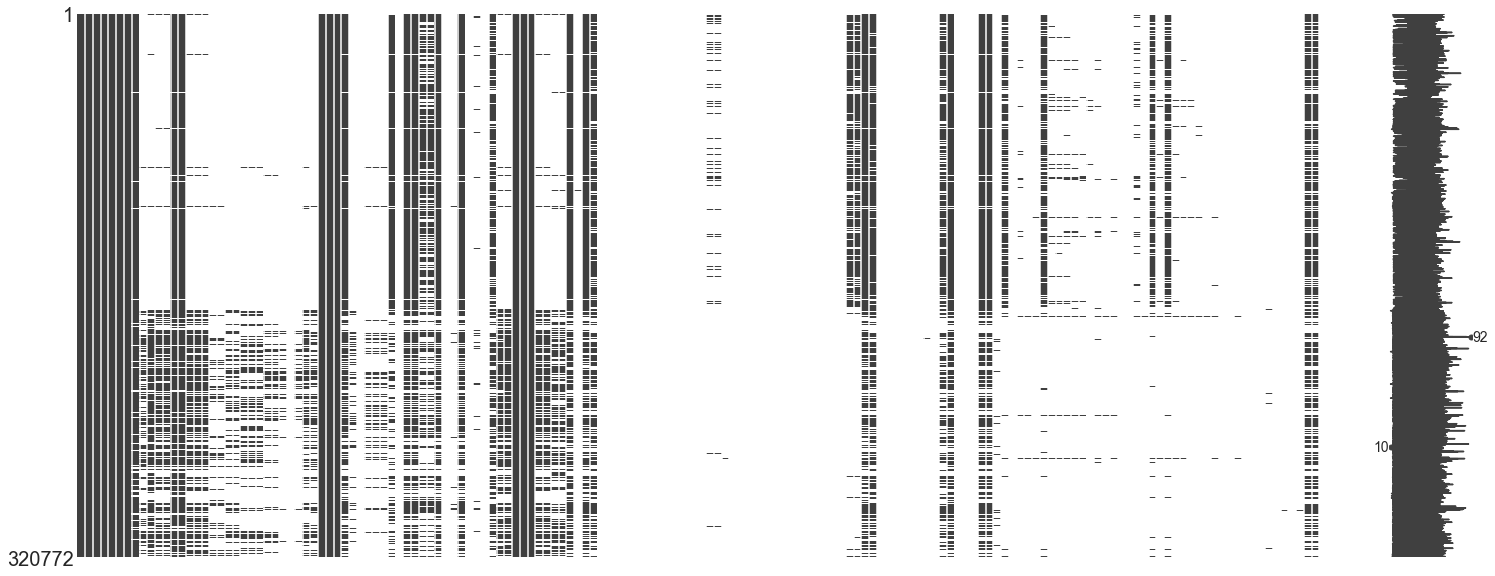

In [327]:
print("Affichage graphique du remplissage des colonnes")
msno.matrix(data)

Il y'a beaucoup de colonnes vides ou très peu remplies (plus de 75% de valeurs manquantes).

<a id="nettoyage"></a>
# Nettoyage du jeu de données

On commence par supprimer les colonnes peu remplies, c'est à dire celles qui ont plus de 75% de valeurs manquantes

In [328]:
# Suppression des colonnes avec plus de 75% de valeurs manquantes
data_cleaned = filterDataColumnByNan(data)

On supprime ensuite les lignes dont aucune donnée nutritionnelle n'a été renseignée (les colonnes terminant par _100g)

In [329]:
# Suppression des lignes sans données nutritionnelles de renseignée
data_cleaned = filterDataRowByNan(data_cleaned)

On supprime les lignes dont le code ou le nom du produit n'est pas renseigné

In [330]:
# On supprime les lignes avec la valeur "code" ou "product name" vide
data_cleaned = filterDataRowByNanInColumn(data_cleaned, 'code')
data_cleaned = filterDataRowByNanInColumn(data_cleaned, 'product_name')

On vérifie si il y a des doublons pour le code des produits

In [331]:
data_cleaned[data_cleaned.duplicated('code')]

Empty DataFrame
Columns: [code, url, creator, created_t, created_datetime, last_modified_t, last_modified_datetime, product_name, quantity, brands, brands_tags, categories, categories_tags, categories_fr, countries, countries_tags, countries_fr, ingredients_text, serving_size, additives_n, additives, additives_tags, additives_fr, ingredients_from_palm_oil_n, ingredients_that_may_be_from_palm_oil_n, nutrition_grade_fr, pnns_groups_1, pnns_groups_2, states, states_tags, states_fr, main_category, main_category_fr, energy_100g, fat_100g, saturated-fat_100g, trans-fat_100g, cholesterol_100g, carbohydrates_100g, sugars_100g, fiber_100g, proteins_100g, salt_100g, sodium_100g, vitamin-a_100g, vitamin-c_100g, calcium_100g, iron_100g, nutrition-score-fr_100g, nutrition-score-uk_100g]
Index: []

[0 rows x 50 columns]

Il n'y pas de doublon à déclarer.

On affiche donc les informations du data après le nettoyage :

In [332]:
displayInfosDataCleaned(data, data_cleaned)

Nombre de lignes supprimées : 61338
Nombre de colonnes supprimées : 112
Colonnes supprimées : ['generic_name', 'packaging', 'packaging_tags', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'image_url', 'image_small_url', 'energy-from-fat_100g', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'monounsatura

Affichage graphique du remplissage des colonnes après le nettoyage


<AxesSubplot:>

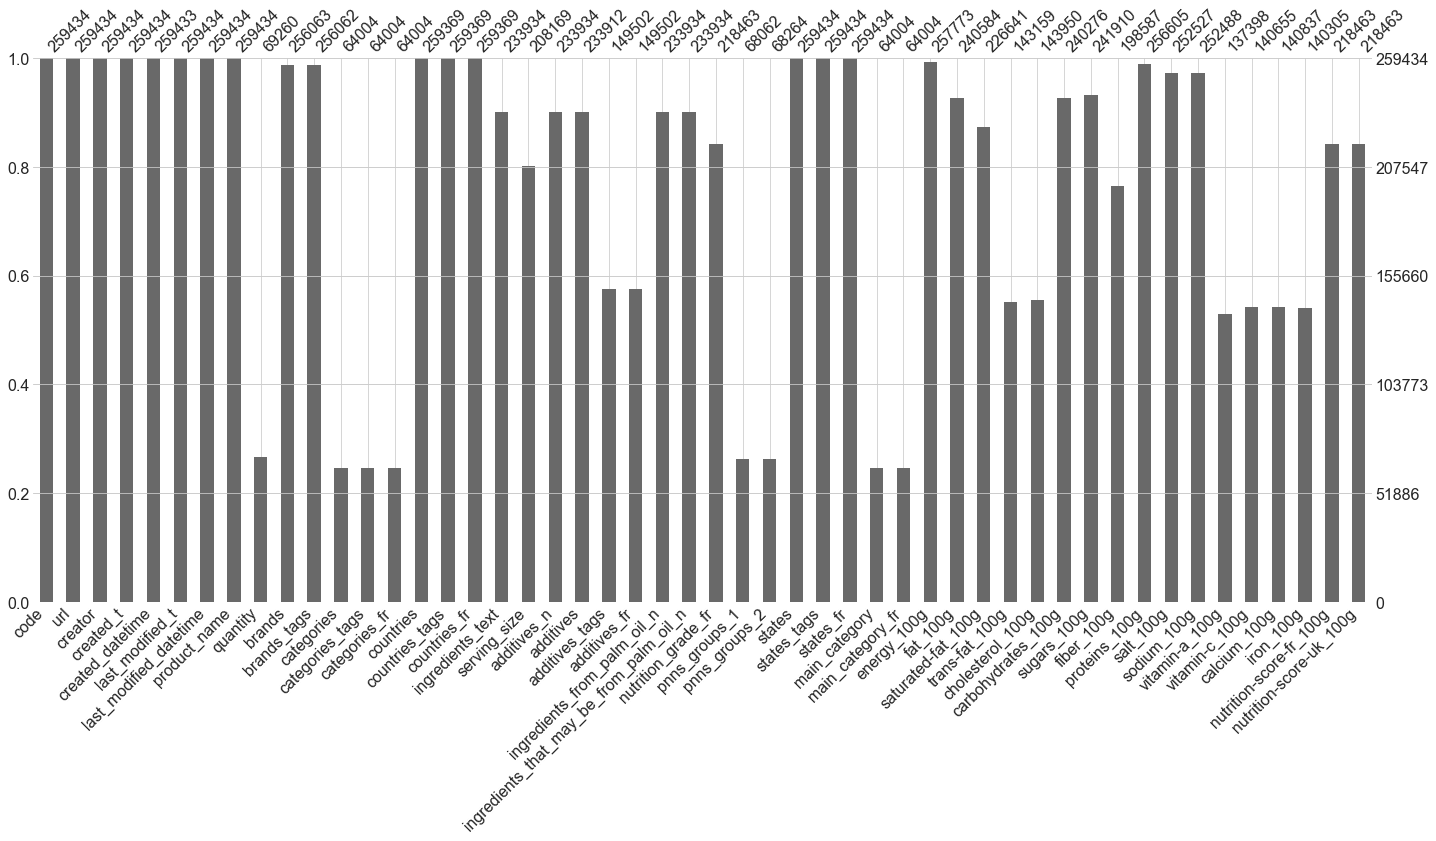

In [333]:
print("Affichage graphique du remplissage des colonnes après le nettoyage")
msno.bar(data_cleaned)

In [334]:
data_cleaned.head(20)

code                                                url  \
1   0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2   0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3   0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
4   0000000016094  http://world-fr.openfoodfacts.org/produit/0000...   
5   0000000016100  http://world-fr.openfoodfacts.org/produit/0000...   
6   0000000016117  http://world-fr.openfoodfacts.org/produit/0000...   
7   0000000016124  http://world-fr.openfoodfacts.org/produit/0000...   
8   0000000016193  http://world-fr.openfoodfacts.org/produit/0000...   
9   0000000016513  http://world-fr.openfoodfacts.org/produit/0000...   
10  0000000016612  http://world-fr.openfoodfacts.org/produit/0000...   
11  0000000016650  http://world-fr.openfoodfacts.org/produit/0000...   
12  0000000016872  http://world-fr.openfoodfacts.org/produit/0000...   
13  0000000016933  http://world-fr.openfoodfacts.org/produit/0000...   
14  0000000017497  http://world-fr.openfoodfacts.org/produit/0000...   
15  0000000018012  http://world-fr.openfoodfacts.org/produit/0000...   
16  0000000018050  http://world-fr.openfoodfacts.org/produit/0000...   
17  0000000018173  http://world-fr.openfoodfacts.org/produit/0000...   
18  0000000018197  http://world-fr.openfoodfacts.org/produit/0000...   
19  0000000018227  http://world-fr.openfoodfacts.org/produit/0000...   
20  0000000018265  http://world-fr.openfoodfacts.org/produit/0000...   

            creator   created_t      created_datetime last_modified_t  \
1   usda-ndb-import  1489069957  2017-03-09T14:32:37Z      1489069957   
2   usda-ndb-import  1489069957  2017-03-09T14:32:37Z      1489069957   
3   usda-ndb-import  1489055731  2017-03-09T10:35:31Z      1489055731   
4   usda-ndb-import  1489055653  2017-03-09T10:34:13Z      1489055653   
5   usda-ndb-import  1489055651  2017-03-09T10:34:11Z      1489055651   
6   usda-ndb-import  1489055730  2017-03-09T10:35:30Z      1489055730   
7   usda-ndb-import  1489055711  2017-03-09T10:35:11Z      1489055712   
8   usda-ndb-import  1489055651  2017-03-09T10:34:11Z      1489055651   
9   usda-ndb-import  1489055654  2017-03-09T10:34:14Z      1489055654   
10  usda-ndb-import  1489055731  2017-03-09T10:35:31Z      1489055731   
11  usda-ndb-import  1489055668  2017-03-09T10:34:28Z      1489055668   
12  usda-ndb-import  1489055650  2017-03-09T10:34:10Z      1489055651   
13  usda-ndb-import  1489055651  2017-03-09T10:34:11Z      1489055651   
14  usda-ndb-import  1489055678  2017-03-09T10:34:38Z      1489055678   
15  usda-ndb-import  1489055652  2017-03-09T10:34:12Z      1489055653   
16  usda-ndb-import  1489050462  2017-03-09T09:07:42Z      1489050462   
17  usda-ndb-import  1489055667  2017-03-09T10:34:27Z      1489055667   
18  usda-ndb-import  1489055652  2017-03-09T10:34:12Z      1489055652   
19  usda-ndb-import  1489055682  2017-03-09T10:34:42Z      1489055682   
20  usda-ndb-import  1489055706  2017-03-09T10:35:06Z      1489055706   

   last_modified_datetime                       product_name quantity  \
1    2017-03-09T14:32:37Z     Banana Chips Sweetened (Whole)      NaN   
2    2017-03-09T14:32:37Z                            Peanuts      NaN   
3    2017-03-09T10:35:31Z             Organic Salted Nut Mix      NaN   
4    2017-03-09T10:34:13Z                    Organic Polenta      NaN   
5    2017-03-09T10:34:11Z  Breadshop Honey Gone Nuts Granola      NaN   
6    2017-03-09T10:35:30Z      Organic Long Grain White Rice      NaN   
7    2017-03-09T10:35:12Z                     Organic Muesli      NaN   
8    2017-03-09T10:34:11Z       Organic Dark Chocolate Minis      NaN   
9    2017-03-09T10:34:14Z              Organic Sunflower Oil      NaN   
10   2017-03-09T10:35:31Z               Organic Adzuki Beans      NaN   
11   2017-03-09T10:34:28Z                Organic Penne Pasta      NaN   
12   2017-03-09T10:34:11Z                      Zen Party Mix      NaN   
13   2017-03-09T1

In [335]:
displayDataShape(data_cleaned)

Le jeu de données contient : 259434 lignes et 50 colonnes



<a id="selection"></a>
# Sélection des données à étudier

Dans cette partie on va sélectionner les données intéressantes pour notre étude

On commence par catégoriser nos variables en 2 groupes : les variables **qualitatives** et **quantitatives**

In [336]:
quanti,quali = categoriseVariables(data_cleaned)
print(f"Variables quantitatives: \n{quanti}\n")
print(f"Variables qualitatives: \n{quali}")

Variables quantitatives: 
['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']

Variables qualitatives: 
['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'serving_size', 'additives', 'additives_tags', 'additives_fr', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr', 'main_category', 'main_category_fr']


À partir de cette catégorisation, on ne va garder que les colonnes pertinentes dans le cas de notre étude :

Pour les variables **qualitatives** on sélectionne :
- product_name
- nutrition_grade_fr
- pnns_groups_1
- pnns_groups_2
- main_category

Pour les variables **quantitatives** on sélectionne :
- energy_100g
- fat_100g
- saturated-fat_100g
- trans-fat_100g
- cholesterol_100g
- carbohydrates_100g
- sugars_100g
- fiber_100g
- proteins_100g
- salt_100g
- sodium_100g
- vitamin-a_100g
- vitamin-c_100g
- calcium_100g
- iron_100g
- nutrition-score-fr_100g

In [337]:
quali = ['product_name', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'main_category']
quanti = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g']

data_selection = data_cleaned[quali + quanti]

In [338]:
displayInfosDataCleaned(data_cleaned, data_selection)

Nombre de lignes supprimées : 0
Nombre de colonnes supprimées : 29
Colonnes supprimées : ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'quantity', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'serving_size', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'states', 'states_tags', 'states_fr', 'main_category_fr', 'nutrition-score-uk_100g']

Le jeu de données contient : 259434 lignes et 21 colonnes



<a id="analyse"></a>
# Analyse des données sélectionnées

## Variables qualitatives
On va ici analyser les données qualitatives

### Nettoyage
On effectue un second nettoyage un peu plus poussé sur les données qualitatives, afin d'uniformiser les données :

- On passe les valeurs en minuscule
- On remplace les valeurs à "unknown" par la valeur Nan

In [339]:
# On passe les valeurs en minuscule
data_selection = lowerStringInColumns(data_selection, quali)
# On remplace les valeurs à "unknown" par Nan
data_selection = cleanDataQuali(data_selection, quali, "unknown", np.nan)
data_selection[quali].head()

product_name nutrition_grade_fr pnns_groups_1  \
1     banana chips sweetened (whole)                  d           NaN   
2                            peanuts                  b           NaN   
3             organic salted nut mix                  d           NaN   
4                    organic polenta                NaN           NaN   
5  breadshop honey gone nuts granola                NaN           NaN   

  pnns_groups_2 main_category  
1           NaN           NaN  
2           NaN           NaN  
3           NaN           NaN  
4           NaN           NaN  
5           NaN           NaN

### Analyse univariée

In [340]:
displayNbrUnique(data_selection, quali)

product_name          183134
nutrition_grade_fr         5
pnns_groups_1             13
pnns_groups_2             36
main_category           2355
dtype: int64

On affiche les graphiques pour les colonnes ne présentant pas trop de valeurs uniques.
On regroupe les valeurs représentant moins de 1.5% des données dans une catégorie nommée 'other'

Graphiques pour les données qualitatives


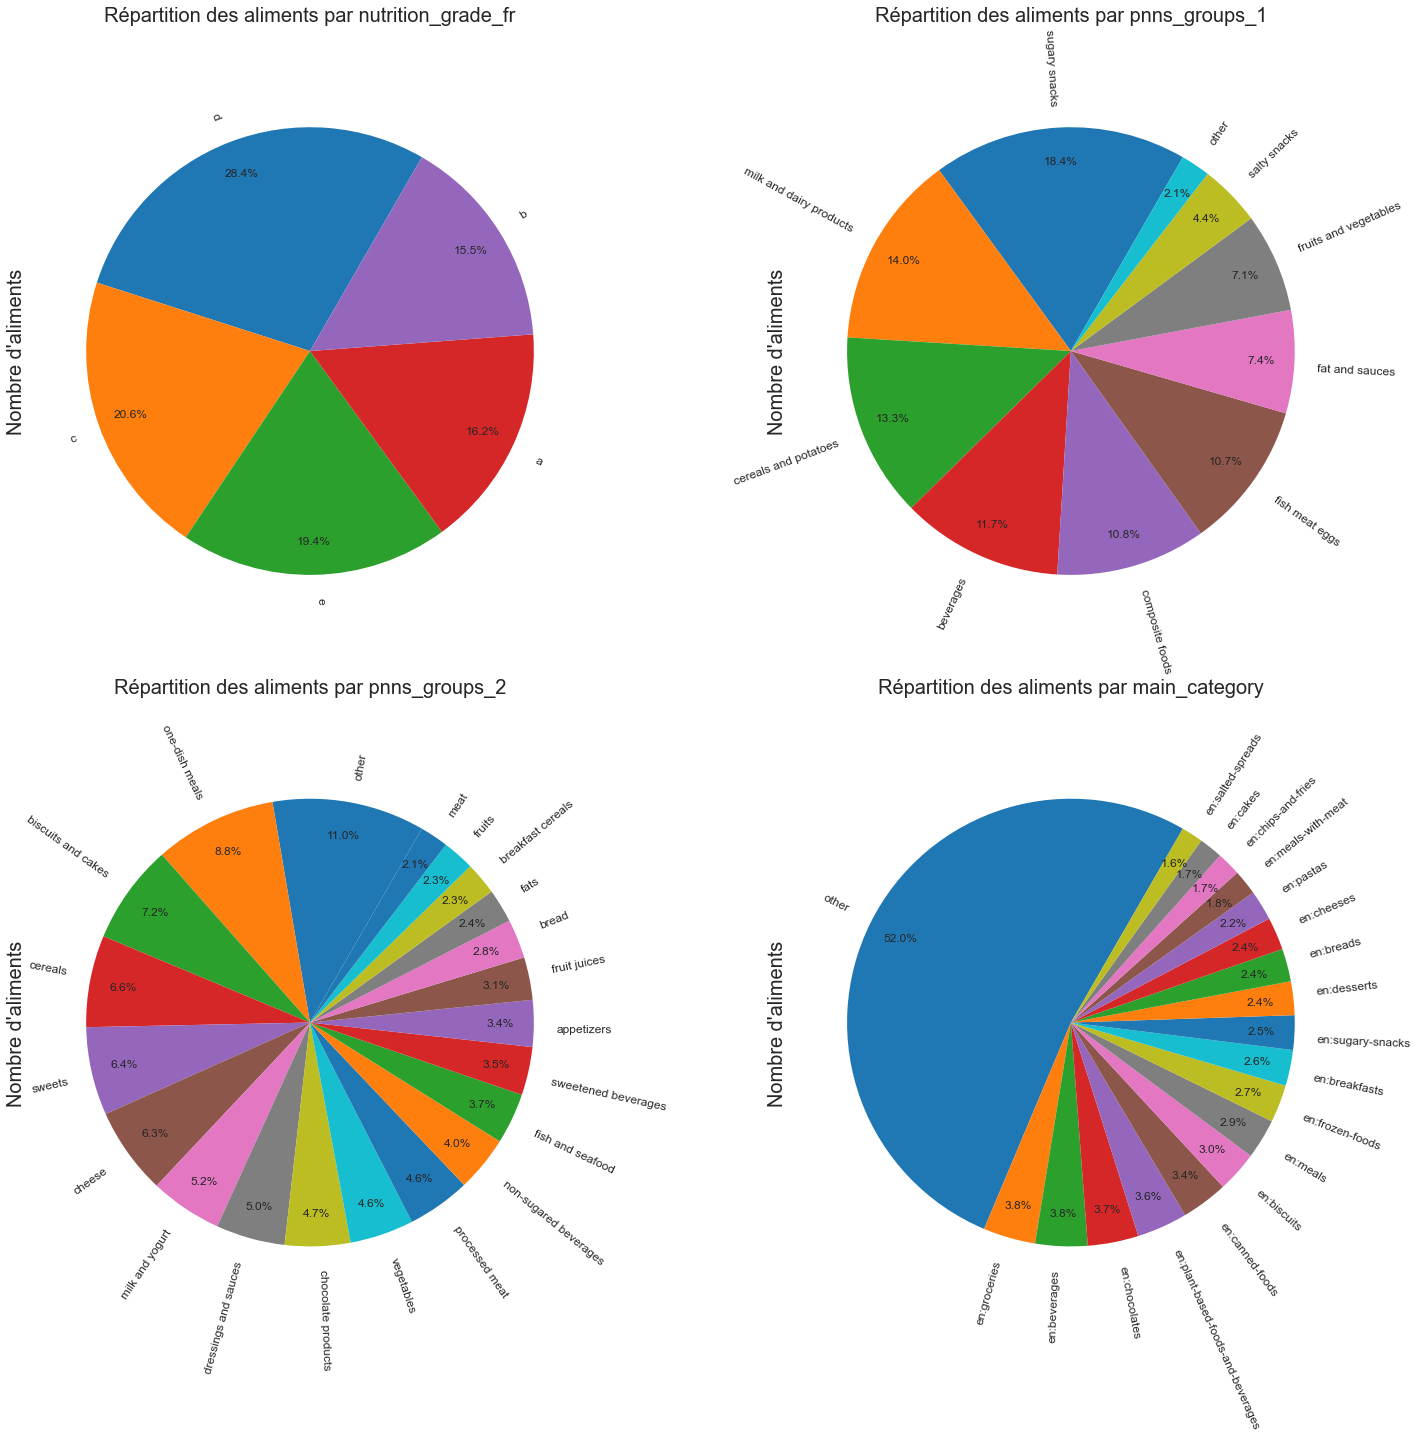

In [341]:
print("Graphiques pour les données qualitatives")
drawPieplot(data_selection, quali, dims_fig)

On voit que la répartition du **nutri-score** (noté de A à E) n'est pas uniforme, il y a une majorité de produits avec un mauvais nutriscore (C, D et E).

Les 19 **catégories** les plus courantes représentent environ 50% des produits.

Pour les différents **groupes d'aliments** (groupes 1 et 2), certains types de produits reviennent beaucoup plus souvents et représentent une plus grande part des données.

### Analyse bivariée

Ici on va afficher les répartition du nutri-score en fonction des autres variables qualitatives

In [342]:
drawRepartitionHist(data_selection, quali, 'nutrition_grade_fr')

On peut voir par exemple que les chocolats, biscuits, cakes, sugary snack ... ont généralement un mauvais nutri-score (D ou E), et que les canettes de nourriture, laits, céréales, fruits ... ont un bon nutri-score (A ou B)

## Variables quantitatives
On va ici analyser les données quantitatives

### Nettoyage

On effectue un second nettoyage un peu plus poussé sur les données quantitatives, afin d'uniformiser les données :

- On supprime les valeurs inférieures à 0 et supérieures à 100 pour les données nutritionnelles
- On supprime les outliers par la méthode de l'inter-quartile pour les autres données
- On supprime les produits dont la somme en g des données nutritionnelles est supérieure à 100
- On supprime les produits dont l'énergie calculée est trop différente de l'énergie renseignée

In [343]:
data_selection[quanti].describe()

energy_100g       fat_100g  saturated-fat_100g  trans-fat_100g  \
count  2.577730e+05  240584.000000       226641.000000   143159.000000   
mean   1.140497e+03      12.701388            5.115709        0.073428   
std    6.484434e+03      17.574028            8.008095        1.540612   
min    0.000000e+00       0.000000            0.000000       -3.570000   
25%    3.730000e+02       0.000000            0.000000        0.000000   
50%    1.100000e+03       5.000000            1.790000        0.000000   
75%    1.674000e+03      20.000000            7.140000        0.000000   
max    3.251373e+06     714.290000          550.000000      369.000000   

       cholesterol_100g  carbohydrates_100g    sugars_100g     fiber_100g  \
count     143950.000000       240276.000000  241910.000000  198587.000000   
mean           0.020079           32.091647      15.993129       2.863581   
std            0.358234           29.765368      22.345150      12.933636   
min            0.000000            0.000000     -17.860000      -6.700000   
25%            0.000000            6.000000       1.300000       0.000000   
50%            0.000000           20.600000       5.710000       1.500000   
75%            0.020000           58.500000      24.000000       3.600000   
max           95.238000         2916.670000    3520.000000    5380.000000   

       proteins_100g      salt_100g    sodium_100g  vitamin-a_100g  \
count  256605.000000  252527.000000  252488.000000   137398.000000   
mean        7.074330       2.037957       0.802467        0.000397   
std         8.418758     129.023620      50.800621        0.073320   
min      -800.000000       0.000000       0.000000       -0.000340   
25%         0.700000       0.063500       0.025000        0.000000   
50%         4.760000       0.584200       0.230000        0.000000   
75%        10.000000       1.379220       0.543000        0.000107   
max       430.000000   64312.800000   25320.000000       26.700000   

       vitamin-c_100g   calcium_100g      iron_100g  nutrition-score-fr_100g  
count    140655.00000  140837.000000  140305.000000            218463.000000  
mean          0.02335       0.125119       0.003654                 9.151724  
std           2.23813       3.320757       0.214528                 9.052588  
min          -0.00210       0.000000      -0.000260               -15.000000  
25%           0.00000       0.000000       0.000000                 1.000000  
50%           0.00000       0.035000       0.001010                10.000000  
75%           0.00370       0.106000       0.002400                16.000000  
max         716.98110     694.737000      50.000000                40.000000

On voit que pour les données nutritionnelles (colonnes terminant par _100g) il y a des incohérences, il y a des valeurs négatives et des valeurs supérieures à 100 ce qui est impossible.
Pour l'énergie et le nutrition-score exprimé en valeur numérique il y a également des abérrations, ici on utilisera la méthode de l'inter-quartile

On va donc supprimer les valeurs en dessous de 0 et au dessous de 100 pour les colonnes suivantes :
- fat_100g
- saturated-fat_100g
- trans-fat_100g
- cholesterol_100g
- carbohydrates_100g
- sugars_100g
- fiber_100g
- proteins_100g
- salt_100g
- sodium_100g
- vitamin-a_100g
- vitamin-c_100g
- calcium_100g
- iron_100g

In [344]:
# Suppression des valeurs inférieures à 0 et supérieures à 100
data_selection_cleaned = cleanDataOutInterval(data_selection, quanti, 0, 100)

Suppression des outliers par la méthode de l'écart inter-quartiles, pour les colonnes suivantes :
- energy_100g
- nutrition-score-fr_100g


In [345]:
outliers = removeOutliers(data_selection_cleaned, ['energy_100g','nutrition-score-fr_100g'])
data_selection_cleaned[['energy_100g','nutrition-score-fr_100g']] = data_selection_cleaned[['energy_100g','nutrition-score-fr_100g']][outliers]
data_selection_cleaned[quanti].describe()

energy_100g       fat_100g  saturated-fat_100g  trans-fat_100g  \
count  256709.000000  240580.000000       226638.000000   143150.000000   
mean     1113.395627      12.696195            5.111649        0.067118   
std       781.536587      17.497914            7.906154        0.944894   
min         0.000000       0.000000            0.000000        0.000000   
25%       372.000000       0.000000            0.000000        0.000000   
50%      1093.000000       5.000000            1.790000        0.000000   
75%      1674.000000      20.000000            7.140000        0.000000   
max      3619.000000     100.000000          100.000000      100.000000   

       cholesterol_100g  carbohydrates_100g    sugars_100g     fiber_100g  \
count     143950.000000        240258.00000  241892.000000  198582.000000   
mean           0.020079            32.07302      15.975216       2.833600   
std            0.358234            29.16708      21.169760       4.591686   
min            0.000000             0.00000       0.000000       0.000000   
25%            0.000000             6.00000       1.300000       0.000000   
50%            0.000000            20.59000       5.710000       1.500000   
75%            0.020000            58.45750      24.000000       3.600000   
max           95.238000           100.00000     100.000000     100.000000   

       proteins_100g      salt_100g    sodium_100g  vitamin-a_100g  \
count  256601.000000  252371.000000  252454.000000   137397.000000   
mean        7.077845       1.593437       0.649009        0.000397   
std         8.163246       6.261328       2.663027        0.073320   
min         0.000000       0.000000       0.000000        0.000000   
25%         0.700000       0.063500       0.025000        0.000000   
50%         4.760000       0.584200       0.230000        0.000000   
75%        10.000000       1.374140       0.543000        0.000107   
max       100.000000     100.000000     100.000000       26.700000   

       vitamin-c_100g   calcium_100g      iron_100g  nutrition-score-fr_100g  
count   140651.000000  140827.000000  140304.000000            218459.000000  
mean         0.014532       0.101944       0.003654                 9.151159  
std          0.461745       0.585645       0.214529                 9.051708  
min          0.000000       0.000000       0.000000               -15.000000  
25%          0.000000       0.000000       0.000000                 1.000000  
50%          0.000000       0.035000       0.001010                10.000000  
75%          0.003700       0.106000       0.002400                16.000000  
max        100.000000      99.006000      50.000000                38.000000

Nos données quantitatives sont maintenant plus uniformes. Analysons comment les étudier :

Les données nutritionnelles principales sont :
- **fat_100g** (lipides), décliné ensuite par les données :
    - saturated-fat_100g
    - trans-fat_100g
    - cholesterol_100g
- **carbohydrates_100g** (glucides), décliné ensuite par les données :
    - sugars_100g
    - fiber_100g
- **proteins_100g** (protéines)

Ces données principales servent à calculer :
- **energy_100g**

Le calcul des calories d'un aliment s'effectue selon un processus normalisé au niveau européen et baptisé système « 4/4/9 »
Ce système implique que l'équivalent calorique d'un gramme de **protéines**, de **glucides** et de **lipides** - nos trois principaux « carburants » nutritionnels - correspond respectivement à **4, 4 et 9 kcal**.

1 gr de proteine apporte 4 kcal
1 gr de glucide (carbohydrate) apporte 4 kcal
1 gr de lipide apporte 9 kcal

On va rajouter 3 colonnes dans notre data :
- **sum_nutritional_elements_100g** : c'est la somme en g des données nutritionnelles principales
- **energy_calculated_100g** : c'est l'énergie calculée à partir des données nutritionnelles principales
- **energy_difference** : c'est la différence d'énergie entre celle calculée et celle renseignée


In [346]:
nutri = ['energy_100g','fat_100g', 'carbohydrates_100g', 'proteins_100g', 'nutrition_grade_fr']

sum_nutritional_elements = []
energy_calculated = []

for index in range(data_selection_cleaned[nutri].shape[0]):
    value_sum = data_selection_cleaned['fat_100g'].iloc[index] + data_selection_cleaned['carbohydrates_100g'].iloc[index] + data_selection_cleaned['proteins_100g'].iloc[index]
    value_energy = (data_selection_cleaned['fat_100g'].iloc[index]*9 + data_selection_cleaned['carbohydrates_100g'].iloc[index]*4 + data_selection_cleaned['proteins_100g'].iloc[index]*4)*4.187

    sum_nutritional_elements.append(value_sum)
    energy_calculated.append(value_energy)

data_selection_cleaned['sum_nutritional_elements_100g'] = sum_nutritional_elements
data_selection_cleaned['energy_calculated_100g'] = energy_calculated
data_selection_cleaned['energy_difference'] = abs(data_selection_cleaned['energy_100g'] - data_selection_cleaned['energy_calculated_100g'])

data_selection_cleaned[['sum_nutritional_elements_100g', 'energy_calculated_100g', 'energy_difference']].describe()

sum_nutritional_elements_100g  energy_calculated_100g  \
count                  238411.000000           238411.000000   
mean                       51.698274             1130.291358   
std                        33.917433              812.105339   
min                         0.000000                0.000000   
25%                        19.250000              363.054770   
50%                        50.000000             1108.424510   
75%                        87.000000             1674.800000   
max                       233.340000             6001.478320   

       energy_difference  
count      237191.000000  
mean           59.553247  
std           146.763682  
min             0.000000  
25%             7.644560  
50%            22.745000  
75%            57.127860  
max          4187.125610

Commencons par supprimer les produits dont la somme en g des valeurs nutritionnelles principales est supérieure à 100, car c'est impossible. Cela signifie que les données sont mal renseignées pour ce produit.

In [347]:
# Suppression des produits dont la somme des valeurs nutritionnelles principales est supérieure à 100
data_selection_cleaned = data_selection_cleaned[data_selection_cleaned['sum_nutritional_elements_100g'] <= 100]

Affichons maintenant le graphique représentant pour les produits la différence entre l'énergie renseignée et celle calculée

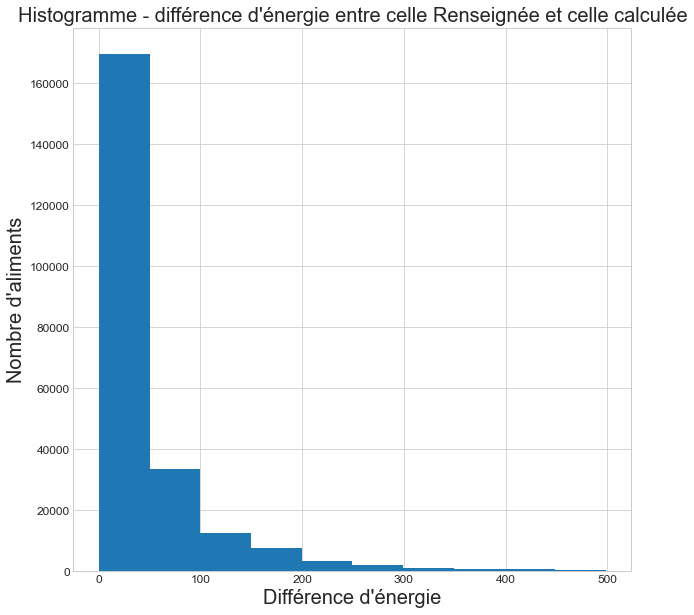

In [348]:
plt.figure(figsize=(10,10))
plt.hist(data_selection_cleaned['energy_difference'][data_selection_cleaned['energy_difference'] < 500])
plt.xlabel("Différence d'énergie")
plt.ylabel("Nombre d'aliments")
plt.title("Histogramme - différence d'énergie entre celle Renseignée et celle calculée")
plt.show()

On voit que pour la majorité des produits la différence d'énergie est très faible, ce qui signifie que notre calcul en utilisant les données nutritionnelles principales et le système 4/4/9 représente assez bien nos données.
On choisit ici de supprimer les produits qui ont une différence supérieure à 300 kJ (correspondant à 72 kcal), cela signifie qu'il manque des données nutritionnelles ou qu'elles sont mal renseignées.
Ceci nous permettra d'avoir des données plus pertinentes pour l'analyse

In [349]:
data_selection_cleaned = data_selection_cleaned[data_selection_cleaned['energy_difference'] <= 300]

In [350]:
data_selection_cleaned = data_selection_cleaned.drop(columns=['sum_nutritional_elements_100g', 'energy_calculated_100g', 'energy_difference'])

In [351]:
data_selection_cleaned[quanti].head(10)

energy_100g  fat_100g  saturated-fat_100g  trans-fat_100g  \
1        2243.0     28.57               28.57             0.0   
2        1941.0     17.86                0.00             0.0   
3        2540.0     57.14                5.36             NaN   
4        1552.0      1.43                 NaN             NaN   
5        1933.0     18.27                1.92             NaN   
7        1833.0     18.75                4.69             NaN   
8        2406.0     37.50               22.50             NaN   
10       1393.0      1.04                 NaN             NaN   
11       1540.0      1.75                 NaN             NaN   
12       2230.0     36.67                5.00             NaN   

    cholesterol_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
1              0.018               64.29        14.29         3.6   
2              0.000               60.71        17.86         7.1   
3                NaN               17.86         3.57         7.1   
4                NaN               77.14          NaN         5.7   
5                NaN               63.46        11.54         7.7   
7                NaN               57.81        15.62         9.4   
8                NaN               55.00        42.50         7.5   
10               NaN               62.50          NaN        12.5   
11               NaN               73.68          NaN         1.8   
12               NaN               36.67         3.33         6.7   

    proteins_100g  salt_100g  sodium_100g  vitamin-a_100g  vitamin-c_100g  \
1            3.57    0.00000        0.000             0.0          0.0214   
2           17.86    0.63500        0.250             0.0          0.0000   
3           17.86    1.22428        0.482             NaN             NaN   
4            8.57        NaN          NaN             NaN             NaN   
5           13.46        NaN          NaN             NaN             NaN   
7           14.06    0.13970        0.055             NaN             NaN   
8            5.00        NaN          NaN             NaN             NaN   
10          22.92        NaN          NaN             NaN             NaN   
11          14.04        NaN          NaN             NaN          0.0042   
12          16.67    1.60782        0.633             NaN             NaN   

    calcium_100g  iron_100g  nutrition-score-fr_100g  
1          0.000    0.00129                     14.0  
2          0.071    0.00129                      0.0  
3          0.143    0.00514                     12.0  
4            NaN        NaN                      NaN  
5          0.038    0.00346                      NaN  
7          0.062    0.00422                      7.0  
8          0.050    0.01125                      NaN  
10         0.062    0.00450                      NaN  
11           NaN    0.00126                      NaN  
12         0.133    0.00360                     12.0

In [352]:
data_selection_cleaned[quanti].describe()

energy_100g       fat_100g  saturated-fat_100g  trans-fat_100g  \
count  229274.000000  229274.000000       201082.000000   137281.000000   
mean     1102.666819      12.285881            4.914001        0.064078   
std       778.964090      16.657231            7.302460        0.923760   
min         0.000000       0.000000            0.000000        0.000000   
25%       364.000000       0.000000            0.000000        0.000000   
50%      1079.000000       5.000000            1.790000        0.000000   
75%      1652.000000      20.000000            7.140000        0.000000   
max      3615.000000     100.000000          100.000000      100.000000   

       cholesterol_100g  carbohydrates_100g    sugars_100g     fiber_100g  \
count     137843.000000       229274.000000  215471.000000  174202.000000   
mean           0.020419           31.532003      15.941584       2.733075   
std            0.365964           28.824391      20.954942       3.907067   
min            0.000000            0.000000       0.000000       0.000000   
25%            0.000000            5.930000       1.500000       0.000000   
50%            0.000000           20.000000       5.880000       1.600000   
75%            0.022000           57.400000      23.900000       3.600000   
max           95.238000          100.000000     100.000000     100.000000   

       proteins_100g      salt_100g    sodium_100g  vitamin-a_100g  \
count  229274.000000  224481.000000  224568.000000   131899.000000   
mean        6.992843       1.561975       0.636671        0.000397   
std         7.952756       6.183544       2.633933        0.074831   
min         0.000000       0.000000       0.000000        0.000000   
25%         0.700000       0.070000       0.027559        0.000000   
50%         4.700000       0.600000       0.236220        0.000000   
75%        10.000000       1.391920       0.549000        0.000107   
max       100.000000     100.000000     100.000000       26.700000   

       vitamin-c_100g   calcium_100g      iron_100g  nutrition-score-fr_100g  
count   134947.000000  135034.000000  134652.000000            194491.000000  
mean         0.011334       0.101030       0.003526                 9.087917  
std          0.297387       0.589846       0.212640                 9.041991  
min          0.000000       0.000000       0.000000               -14.000000  
25%          0.000000       0.000000       0.000000                 1.000000  
50%          0.000000       0.035000       0.000970                10.000000  
75%          0.003800       0.106000       0.002400                16.000000  
max         57.140000      99.006000      50.000000                37.000000

In [353]:
# Affichage des informations sur le nouveau jeu de données
displayInfosDataCleaned(data_selection, data_selection_cleaned)

Nombre de lignes supprimées : 30160
Nombre de colonnes supprimées : 0
Colonnes supprimées : []

Le jeu de données contient : 229274 lignes et 22 colonnes



In [354]:
displayNanPercent(data_selection_cleaned)

Valeurs manquantes en %
product_name                            0.000000
proteins_100g                           0.000000
fat_100g                                0.000000
energy_100g                             0.000000
carbohydrates_100g                      0.000000
sodium_100g                             2.052566
salt_100g                               2.090512
sugars_100g                             6.020308
saturated-fat_100g                     12.296205
nutrition_grade_fr                     15.170495
nutrition-score-fr_100g                15.170931
fiber_100g                             24.020168
cholesterol_100g                       39.878486
trans-fat_100g                         40.123608
calcium_100g                           41.103658
vitamin-c_100g                         41.141603
iron_100g                              41.270271
vitamin-a_100g                         42.471017
main_category                          74.799585
pnns_groups_2                          77.996633
pnns_groups_1                          78.043738
top_pnns_groups_1                      78.043738

### Analyse univariée

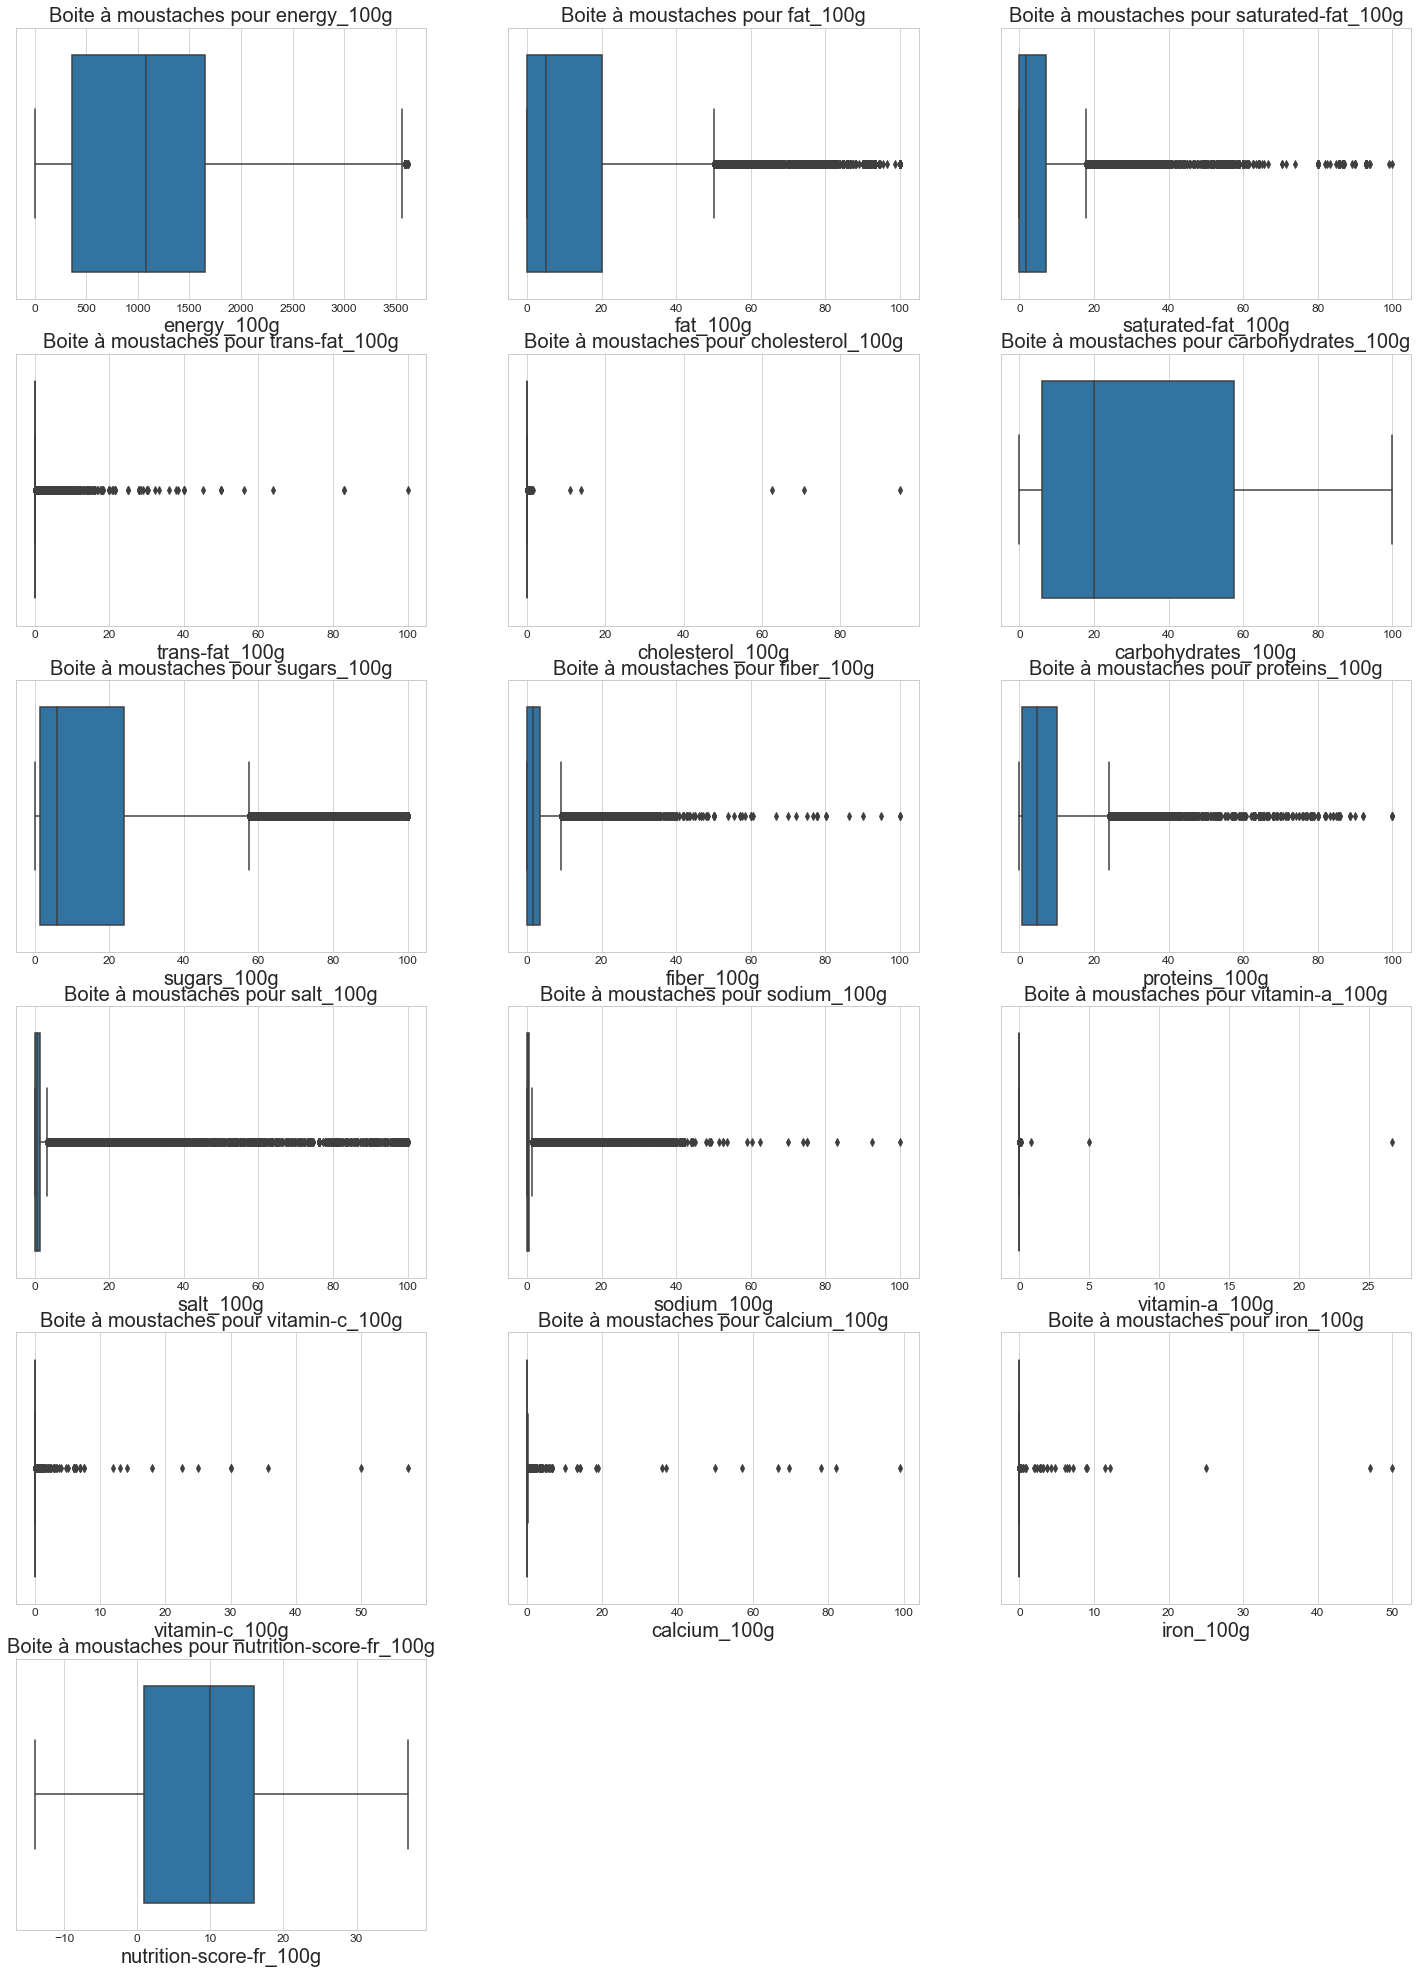

In [355]:
drawBoxPlot(data_selection_cleaned, quanti, dims_fig)

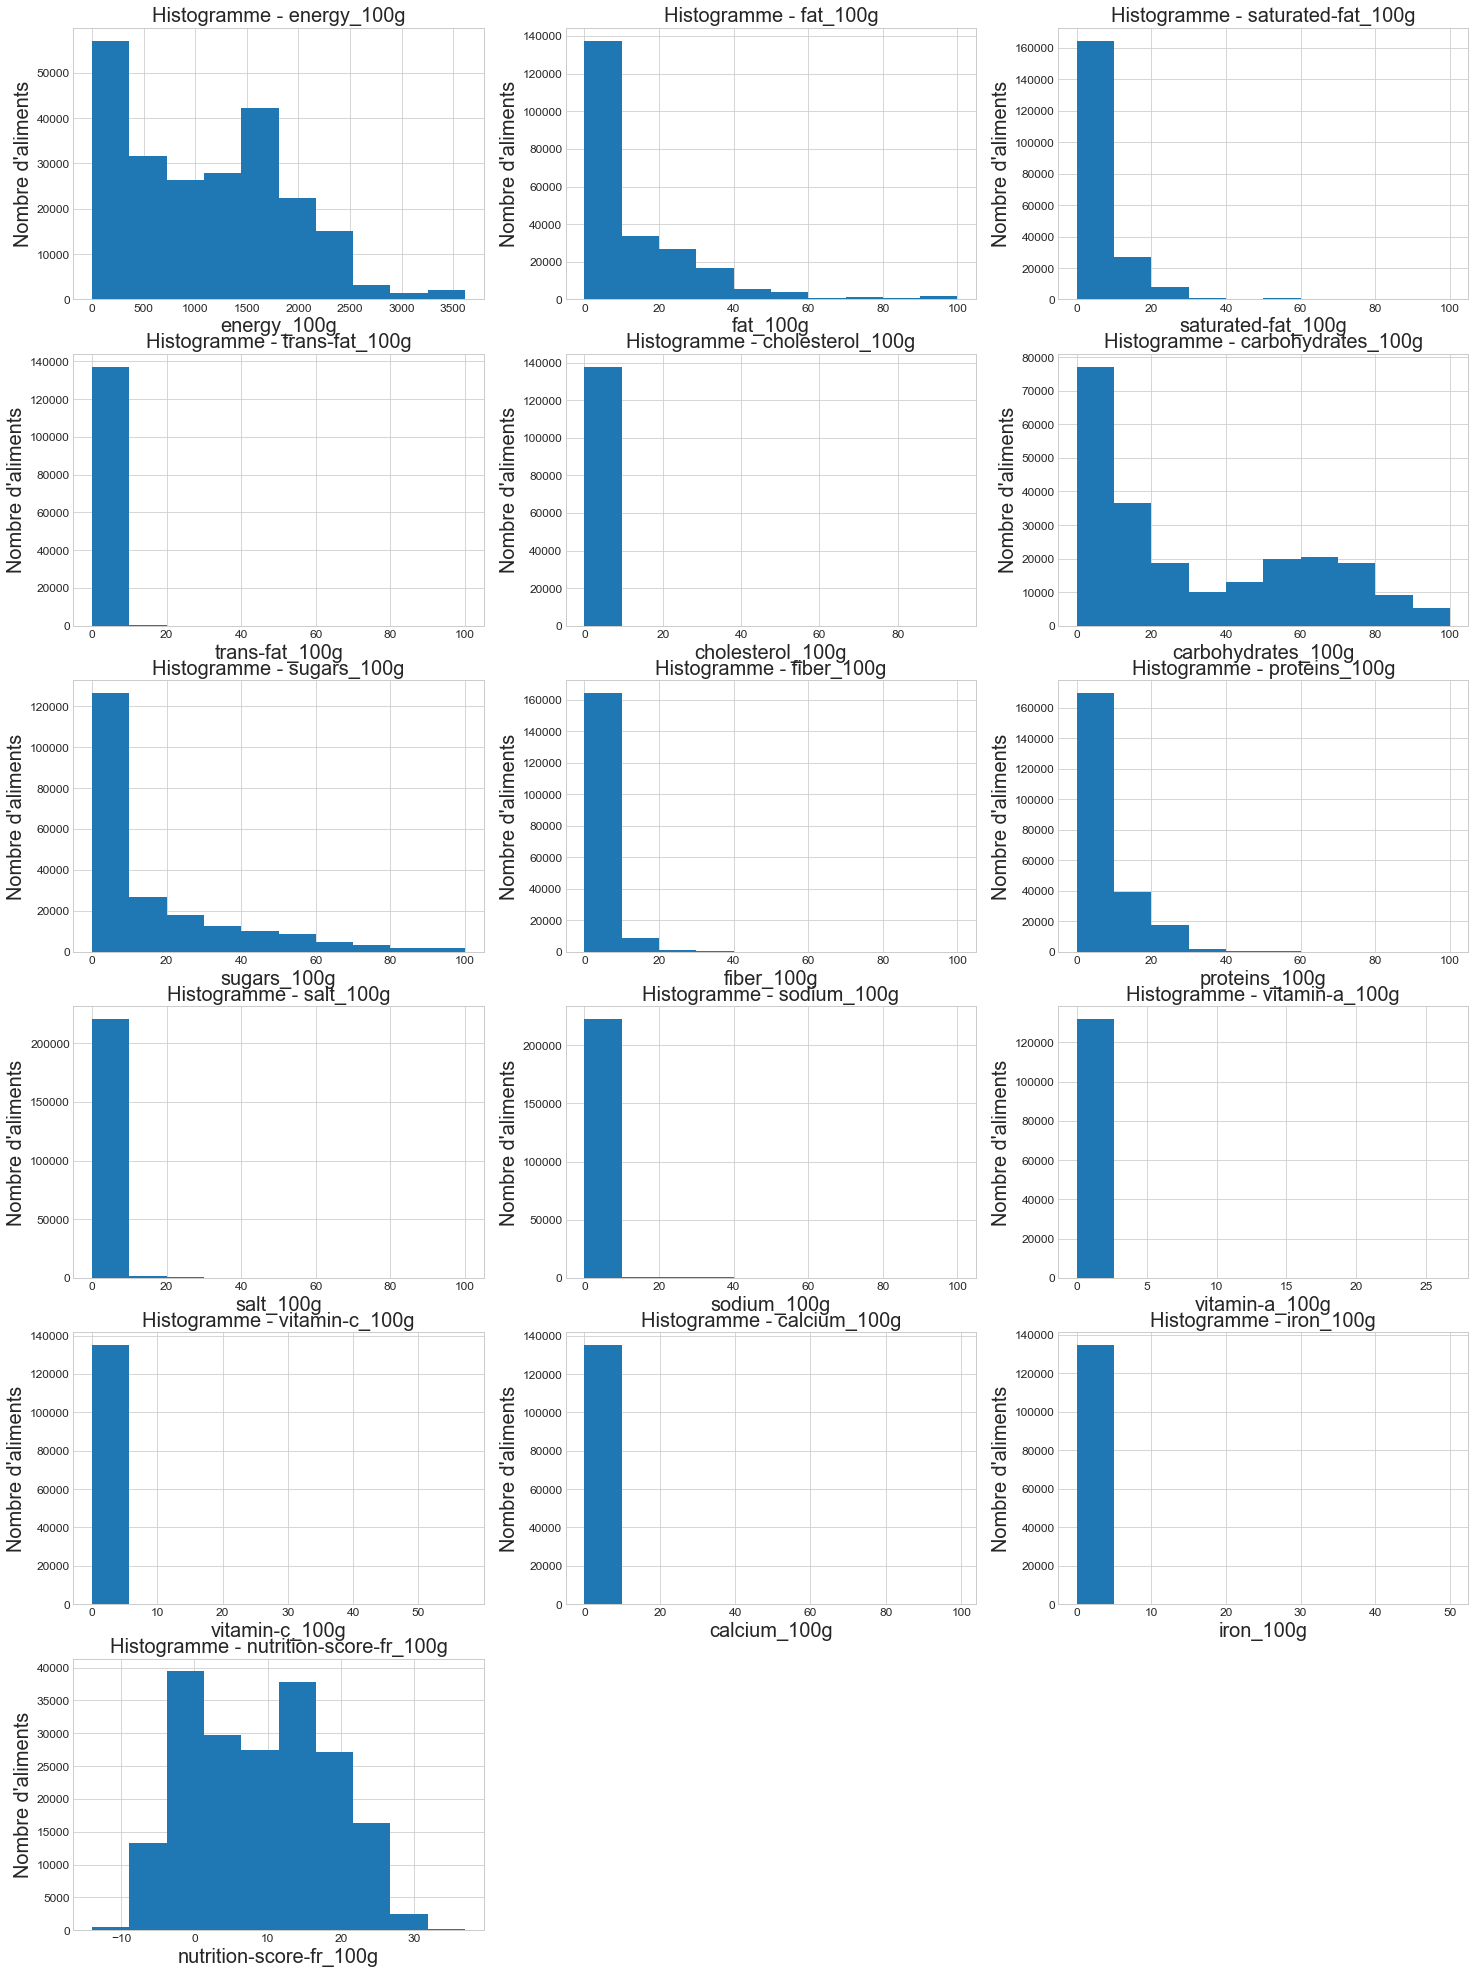

In [356]:
drawHist(data_selection_cleaned, quanti, dims_fig)

In [357]:
data_knn = data_selection_cleaned.copy()
data_knn

product_name nutrition_grade_fr  \
1                          banana chips sweetened (whole)                  d   
2                                                 peanuts                  b   
3                                  organic salted nut mix                  d   
4                                         organic polenta                NaN   
5                       breadshop honey gone nuts granola                NaN   
...                                                   ...                ...   
320742                                    natural cassava                  a   
320750                                  raspados ice bars                NaN   
320751                tartines craquantes bio au sarrasin                  a   
320763                                 thé vert earl grey                  c   
320768  mint melange tea a blend of peppermint, lemon ...                  b   

               pnns_groups_1          pnns_groups_2  main_category  \
1                        NaN                    NaN            NaN   
2                        NaN                    NaN            NaN   
3                        NaN                    NaN            NaN   
4                        NaN                    NaN            NaN   
5                        NaN                    NaN            NaN   
...                      ...                    ...            ...   
320742                   NaN                    NaN            NaN   
320750                   NaN                    NaN            NaN   
320751  cereals and potatoes                  bread      en:breads   
320763             beverages  non-sugared beverages  en:green-teas   
320768                   NaN                    NaN            NaN   

        energy_100g  fat_100g  saturated-fat_100g  trans-fat_100g  \
1            2243.0     28.57               28.57             0.0   
2            1941.0     17.86                0.00             0.0   
3            2540.0     57.14                5.36             NaN   
4            1552.0      1.43                 NaN             NaN   
5            1933.0     18.27                1.92             NaN   
...             ...       ...                 ...             ...   
320742       1477.0      0.00                0.00             0.0   
320750        368.0      0.00                 NaN             NaN   
320751       1643.0      2.80                0.60             NaN   
320763         21.0      0.20                0.20             NaN   
320768          0.0      0.00                0.00             0.0   

        cholesterol_100g  ...  fiber_100g  proteins_100g  salt_100g  \
1                  0.018  ...         3.6           3.57    0.00000   
2                  0.000  ...         7.1          17.86    0.63500   
3                    NaN  ...         7.1          17.86    1.22428   
4                    NaN  ...         5.7           8.57        NaN   
5                    NaN  ...         7.7          13.46        NaN   
...                  ...  ...         ...            ...        ...   
320742             0.000  ...         4.7           1.18    0.03048   
320750               NaN  ...         NaN           0.00    0.04572   
320751               NaN  ...         5.9          13.00    0.68000   
320763               NaN  ...         0.2           0.50    0.02540   
320768             0.000  ...         0.0           0.00    0.00000   

        sodium_100g  vitamin-a_100g  vitamin-c_100g  calcium_100g  iron_100g  \
1          0.000000             0.0          0.0214         0.000    0.00129   
2          0.250000             0.0          0.0000         0.071    0.00129   
3          0.482000             NaN             NaN         0.143    0.00514   
4               NaN             NaN             NaN           NaN        NaN   
5               NaN             NaN             NaN         0.038    0.00346   
...             ...             ...             ...           ...        ...   
3

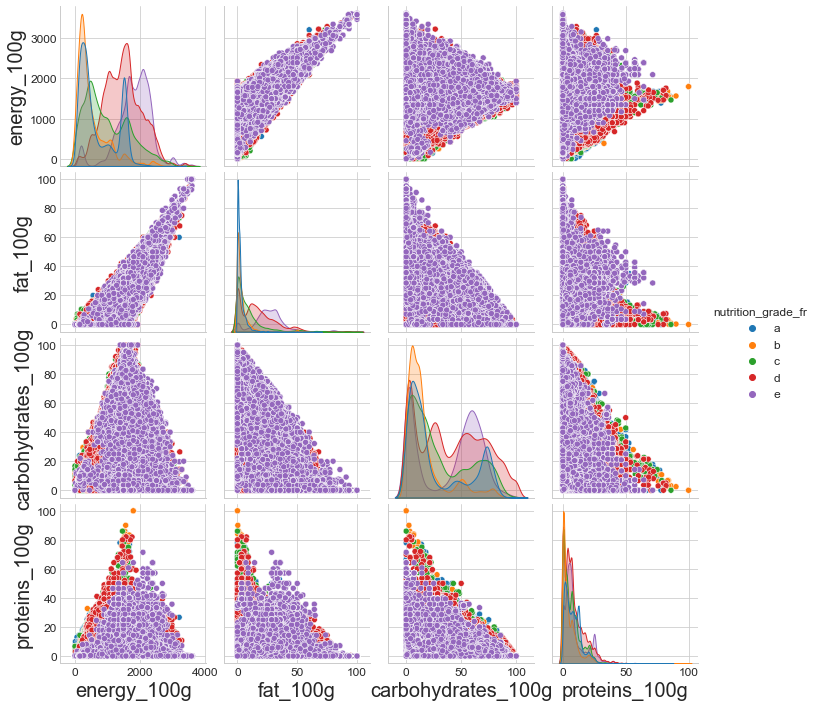

In [362]:
sns.pairplot(data_selection_cleaned[nutri].sort_values(by='nutrition_grade_fr'), hue='nutrition_grade_fr')
plt.show()

In [359]:
column_corr = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g','carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'nutrition-score-fr_100g']

<AxesSubplot:>

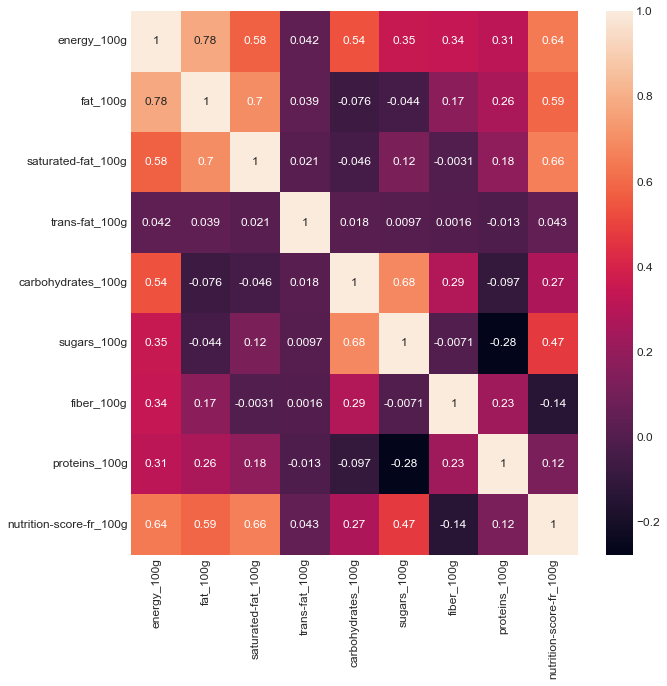

In [360]:
plt.figure(figsize = (10,10))
sns.heatmap(data_selection_cleaned[column_corr].corr(), annot=True)